Given are 15 distinguishing factors that can provide insight into what grade of the glass is being produced. Your objective as a data scientist is to build a machine learning model that can predict the grade of glass based on the given factors.
Data Description:-

The unzipped folder will have the following files.

    Train.csv – 1358 observations.
    Test.csv – 583 observations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss


%matplotlib inline

In [2]:
train = pd.read_csv('data/Glass_Quality_Participants_Data/Train.csv')
test = pd.read_csv('data/Glass_Quality_Participants_Data/Test.csv')

print("Data size: {tr} training dims ; {ts} testing dims".format(tr=train.shape, ts=test.shape))

Data size: (1358, 16) training dims ; (583, 15) testing dims


In [3]:
train.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [4]:
test.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,0,123,65,33,54,1646439,1646893,632,632.391749,0,1,0,0,0
1,0,1,158,99,125,132,189874,189529,421,421.928609,0,0,0,0,0
2,0,1,120,35,64,75,12986873,12986862,272,272.212214,1,0,0,0,0
3,0,1,130,39,57,177,309634,310824,3312,3312.310581,0,0,1,0,0
4,1,0,142,75,23,79,5368307,5367467,862,862.499179,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 16 columns):
grade_A_Component_1    1358 non-null int64
grade_A_Component_2    1358 non-null int64
max_luminosity         1358 non-null int64
thickness              1358 non-null int64
xmin                   1358 non-null int64
xmax                   1358 non-null int64
ymin                   1358 non-null int64
ymax                   1358 non-null int64
pixel_area             1358 non-null int64
log_area               1358 non-null float64
x_component_1          1358 non-null int64
x_component_2          1358 non-null int64
x_component_3          1358 non-null int64
x_component_4          1358 non-null int64
x_component_5          1358 non-null int64
class                  1358 non-null int64
dtypes: float64(1), int64(15)
memory usage: 169.9 KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 15 columns):
grade_A_Component_1    583 non-null int64
grade_A_Component_2    583 non-null int64
max_luminosity         583 non-null int64
thickness              583 non-null int64
xmin                   583 non-null int64
xmax                   583 non-null int64
ymin                   583 non-null int64
ymax                   583 non-null int64
pixel_area             583 non-null int64
log_area               583 non-null float64
x_component_1          583 non-null int64
x_component_2          583 non-null int64
x_component_3          583 non-null int64
x_component_4          583 non-null int64
x_component_5          583 non-null int64
dtypes: float64(1), int64(14)
memory usage: 68.4 KB


In [7]:
train['class'].value_counts()

1    887
2    471
Name: class, dtype: int64

In [8]:
# checking if grade_component attributes are one-hot pairs. Turns out they are! - min/max = 1 for train and test

# min(test.loc[:,['grade_A_Component_1', 'grade_A_Component_2']].sum(axis=1).values)
max(train.loc[:,['grade_A_Component_1', 'grade_A_Component_2']].sum(axis=1).values)

1

In [9]:
# checking x_component attributes ; they're one-hot with all zeros. Both train and test.

# max(test.loc[:,['x_component_1', 'x_component_2', 'x_component_3', 'x_component_4', 'x_component_5']].sum(axis=1).values)
min(train.loc[:,['x_component_1', 'x_component_2', 'x_component_3', 'x_component_4', 'x_component_5']].sum(axis=1).values)

0

<Figure size 864x576 with 0 Axes>

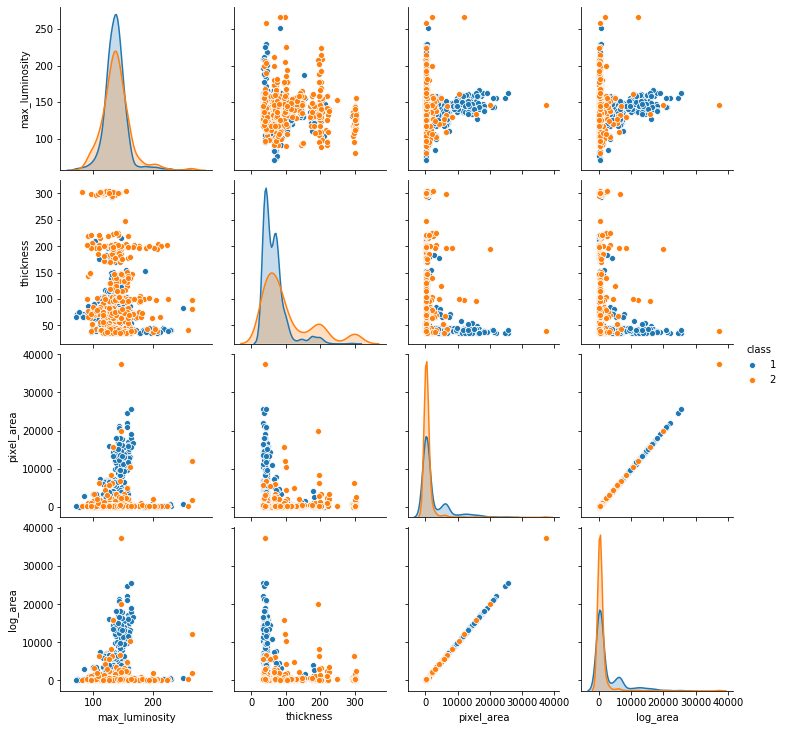

In [10]:
plt.figure(figsize=(12,8))
sns.pairplot(train, hue='class', vars=['max_luminosity', 'thickness', 'pixel_area', 'log_area'])

### Observations

- `log_area` and `pixel_area` share a linear relationship
    - Lower values of `log_area` / `pixel_area` mostly belonging to class `2`
    - Higher values of `log_area` / `pixel_area` mostly belonging to class `1`
    
- Dropping `log_area` in preference to `pixel_area` is logical.


About label encoding `grade_A_Component_1` and `grade_A_Component_2`:
    
- They're one-hot in nature and mutually exclusive

Similarly, for label encoding `x_component_1`...`x_component_5`:

- They're one-hot in nature, but aren't exactly mutually exclusive. All zeros exist in data.

In [11]:
for data in (train , test):
    data['grade_component'] = data.loc[:,['grade_A_Component_1', 'grade_A_Component_2']].sum(axis=1)
    data.loc[data['grade_A_Component_2'] == 1, 'grade_component'] = 2

# checking
train.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class,grade_component
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1,2
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2,1
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1,2
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2,1


In [12]:
for data in (train , test):
    data['x_component'] = 0
    
    data.loc[data['x_component_1'] == 1, 'x_component'] = 1
    data.loc[data['x_component_2'] == 1, 'x_component'] = 2
    data.loc[data['x_component_3'] == 1, 'x_component'] = 3
    data.loc[data['x_component_4'] == 1, 'x_component'] = 4
    data.loc[data['x_component_5'] == 1, 'x_component'] = 5

In [13]:
train['x_component'].unique()

array([3, 1, 0, 2, 4, 5])

In [14]:
# Engineer features from x/y minmax.
# Drop the parent features after they're engineered.

for data in (train, test):
    data['xs'] = data.loc[:,['xmin', 'xmax']].sum(axis=1)
    data['xs'] /= 2
    data['ys'] = data.loc[:,['ymin', 'ymax']].sum(axis=1)
    data['ys'] /= 2


In [15]:
feature_subset = train.drop(['xmin', 'xmax', 'ymin', 'ymax', 'log_area', 'x_component_1', 
                             'x_component_2', 'x_component_3', 'x_component_4', 'x_component_5', 
                             'grade_A_Component_1', 'grade_A_Component_2', 'class'], axis=1).columns
feature_subset

Index(['max_luminosity', 'thickness', 'pixel_area', 'grade_component',
       'x_component', 'xs', 'ys'],
      dtype='object')

In [16]:
scaler = StandardScaler()

X = train.drop(['class'], axis=1)
y = train['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=8, test_size=0.2, stratify=y)

In [17]:
# model = GradientBoostingClassifier()
# param_grid = {"learning_rate":[0.1, 0.07, 0.05], "n_estimators":[100,150,200,250,300,400,500,600], "max_depth":[3,4,5,6]}

model = RandomForestClassifier(random_state=42)
param_grid = {"criterion":["gini", "entropy"], "min_samples_split":[2, 3, 4], "max_features":[None, 'auto'], 
              "n_estimators":[100,150, 200,250,300,400,500,600], "max_depth":[3,4,5,6,7,8], 
              "class_weight":["balanced", "balanced_subsample"]}


grid_clf = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2)

In [18]:
pipe_clf = Pipeline(steps=[('scaler', scaler), ('clf', grid_clf)])
# pipe_clf = Pipeline(steps=[('clf', grid_clf)])

pipe_clf.fit(X_train[feature_subset], y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 33.1min finished


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                         

In [19]:
y_pred = pipe_clf.predict(X_val[feature_subset])

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.78      0.86       178
           2       0.69      0.94      0.79        94

    accuracy                           0.83       272
   macro avg       0.82      0.86      0.82       272
weighted avg       0.86      0.83      0.83       272



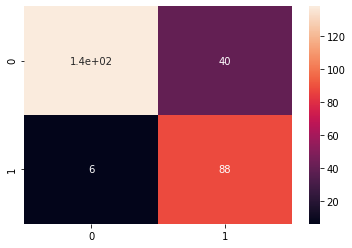

In [20]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)

In [21]:
# Competition eval metric.

y_pred = pipe_clf.predict_proba(X_val[feature_subset])
log_loss(y_val, y_pred)

0.308560026768538

In [22]:
# Now, for the full training.

pipe_clf.fit(X[feature_subset], y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 38.5min finished


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                         

In [23]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
y_pred = pipe_clf.predict_proba(test[feature_subset])

In [25]:
y_pred = pd.DataFrame(y_pred, columns=["1", "2"])

y_pred["1"].apply(lambda x: round(x,5))# if isinstance(x, np.float64) else x)
y_pred["2"].apply(lambda x: round(x,5))# if isinstance(x, np.float64) else x)

y_pred

,1,2
0,1.000000,0.000000
1,0.041998,0.958002
2,1.000000,0.000000
3,1.000000,0.000000
4,0.499664,0.500336
...,...,...
578,0.988991,0.011009
579,1.000000,0.000000
580,1.000000,0.000000
581,1.000000,0.000000


In [26]:
y_pred.to_excel('data/Glass_Quality_Participants_Data/Submission_rf.xlsx', index=False)